# Neural network models (test)

__Obejctive:__ experiment with generating data and fitting a NN model to predict the root.

In [179]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sys.path.append('../modules/')

from logger import get_logger
from tree_generation import generate_dataset_lognormal
from models import FFNN
from training import training_step, EarlyStopper
from plotting import plot_training_history

sns.set_theme()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Available device:', device)

logger = get_logger('nn_test')

%load_ext autoreload
%autoreload 2

Available device: cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate dataset

In [5]:
n_samples = 10000
k = 5
q = 10
sigma = 2.

rho, trees, roots, leaves = generate_dataset_lognormal(n_samples, k, q, sigma)

In [9]:
roots, leaves

(array([6, 0, 9, ..., 0, 5, 0]),
 array([[9, 5, 3, ..., 1, 5, 8],
        [1, 8, 4, ..., 4, 7, 1],
        [4, 5, 7, ..., 4, 8, 9],
        ...,
        [3, 6, 4, ..., 7, 9, 2],
        [4, 8, 4, ..., 6, 5, 5],
        [7, 1, 7, ..., 0, 6, 4]]))

In [13]:
leaves.shape[-1]

32

In [216]:
# Save generated data.
# with open('../data/exp_1/rho.npy', 'wb') as f:
#     np.save(f, rho)

# with open('../data/exp_1/roots.npy', 'wb') as f:
#     np.save(f, roots)

# with open('../data/exp_1/trees.npy', 'wb') as f:
#     np.save(f, trees)

# with open('../data/exp_1/leaves.npy', 'wb') as f:
#     np.save(f, leaves)

In [223]:
# To load a saved dataset.
# with open('../data/exp_1/rho.npy', 'rb') as f:
#     rho = np.load(f)

# with open('../data/exp_1/roots.npy', 'rb') as f:
#     roots = np.load(f)

# with open('../data/exp_1/trees.npy', 'rb') as f:
#     trees = np.load(f)

# with open('../data/exp_1/leaves.npy', 'rb') as f:
#     leaves = np.load(f)

## Model

In [166]:
# Train-test split.
test_frac = .2

test_indices = np.random.choice(range(leaves.shape[0]), int(leaves.shape[0] * test_frac), replace=False)
train_indices = np.array(list(set(range(leaves.shape[0])) - set(test_indices)))

x_train = torch.from_numpy(leaves[train_indices, :]).to(dtype=torch.float32).to(device=device)
y_train = torch.nn.functional.one_hot(torch.from_numpy(roots[train_indices])).to(dtype=torch.float32).to(device=device)
x_test = torch.from_numpy(leaves[test_indices, :]).to(dtype=torch.float32).to(device=device)
y_test = torch.nn.functional.one_hot(torch.from_numpy(roots[test_indices])).to(dtype=torch.float32).to(device=device)

In [225]:
model = FFNN(
    dims=[leaves.shape[-1], 64, 32, q],
    activation='relu',
    output_activation='softmax',
    batch_normalization=False
).to(device=device)

loss_fn = torch.nn.CrossEntropyLoss()

epoch_counter = 0

training_history = {
    'training_loss': [],
    'val_loss': []
}

# Test.
loss_fn(
    model(x_train),
    y_train
)

tensor(2.3035, device='cuda:0', grad_fn=<DivBackward1>)

2024-03-07 19:30:17,752 - nn_test - DEBUG - Epoch: 1 | Training loss: 2.3033199310302734 | Validation loss: 2.303513288497925
2024-03-07 19:30:18,057 - nn_test - DEBUG - Epoch: 2 | Training loss: 2.301543712615967 | Validation loss: 2.3047096729278564
2024-03-07 19:30:18,361 - nn_test - DEBUG - Epoch: 3 | Training loss: 2.3001770973205566 | Validation loss: 2.3077454566955566
2024-03-07 19:30:18,664 - nn_test - DEBUG - Epoch: 4 | Training loss: 2.298431158065796 | Validation loss: 2.3076188564300537
2024-03-07 19:30:18,968 - nn_test - DEBUG - Epoch: 5 | Training loss: 2.2965903282165527 | Validation loss: 2.305889844894409
2024-03-07 19:30:19,271 - nn_test - DEBUG - Epoch: 6 | Training loss: 2.294574737548828 | Validation loss: 2.3089592456817627
2024-03-07 19:30:19,574 - nn_test - DEBUG - Epoch: 7 | Training loss: 2.292358875274658 | Validation loss: 2.310422658920288
2024-03-07 19:30:19,876 - nn_test - DEBUG - Epoch: 8 | Training loss: 2.289034605026245 | Validation loss: 2.312790393

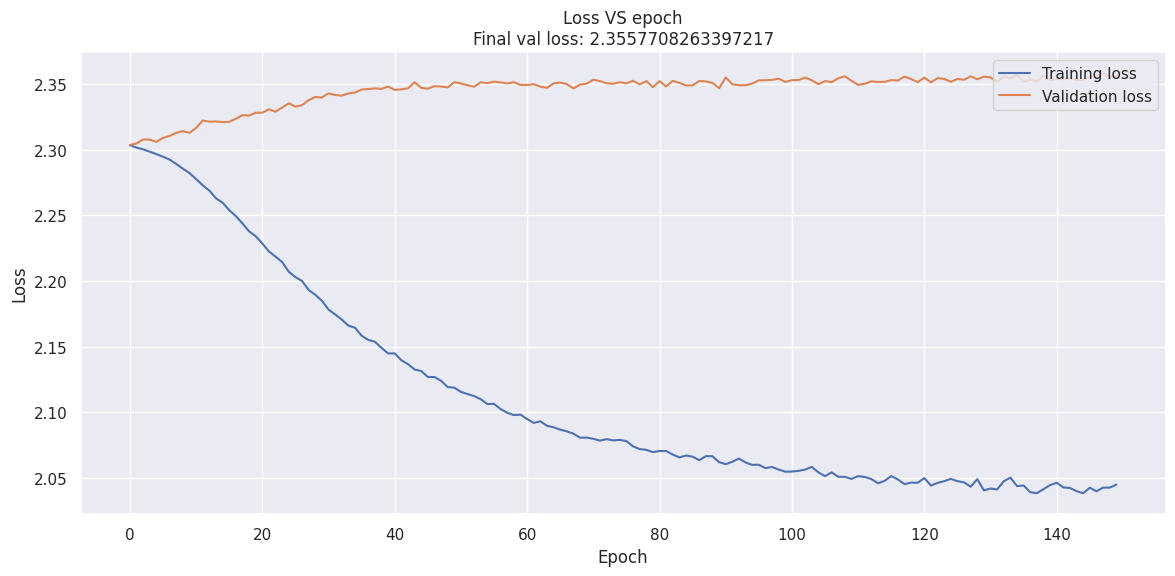

In [226]:
learning_rate = 1e-3
batch_size = 32

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=learning_rate
)

# early_stopper = EarlyStopper(
#     patience=5,
#     min_delta=0.
# )
early_stopper = None

training_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train, y_train),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

n_epochs = 150

# Training loop.
for i in range(n_epochs):
    epoch_counter += 1

    training_loss_batches = []

    for batch in training_loader:
        training_batch, training_targets = batch
    
        training_loss_batch, _ = training_step(
            (training_batch, training_targets),
            model,
            loss_fn,
            optimizer,
        )

        training_loss_batches.append(training_loss_batch.cpu())

    # Training loss for one epoch is computed as the average training
    # loss over the batches.
    training_loss = np.mean(training_loss_batches)

    training_history['training_loss'].append(float(training_loss))

    if x_test is not None:
        with torch.no_grad():
            # val_loss = loss_fn(model(x_test), y_test).numpy()
            val_loss = loss_fn(model(x_test), y_test)
    else:
        val_loss = None

    training_history['val_loss'].append(
        float(val_loss) if val_loss is not None else None
    )
    

    if (i < 50) or (i % 50 == 0):
        logger.debug(
            f'Epoch: {epoch_counter}'
            f' | Training loss: {training_history["training_loss"][-1]}'
            f' | Validation loss: {training_history["val_loss"][-1]}'
        )

    if (x_test is not None) and (early_stopper is not None):
        if early_stopper.early_stop(training_history['val_loss'][-1]):
            logger.debug(
                f'Early stopping epoch: {epoch_counter}'
                f' | Training loss: {training_history["training_loss"][-1]}'
                f' | Validation loss: {training_history["val_loss"][-1]}'
            )
            
            break
    elif (early_stopper is not None):
        if early_stopper.early_stop(training_history['training_loss'][-1]):
            logger.debug(
                f'Early stopping epoch: {epoch_counter}'
                f' | Training loss: {training_history["training_loss"][-1]}'
            )
            
            break

logger.info(f'Last epoch: {epoch_counter}')

plot_training_history(training_history)

test_accuracy = (torch.argmax(model(x_test), axis=-1) == torch.argmax(y_test, axis=-1)).to(dtype=torch.float32).mean().cpu().numpy()
baseline_accuracy = 1. / q

logger.info(f'Test accuracy: {test_accuracy} (baseline: {baseline_accuracy})')